In [ ]:
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info = True,
                           as_supervised = True)

train_examples, val_examples = examples['train'], examples['validation']
print(info)


tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_dir='/root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    file_format=tfrecord,
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=string),
        'pt': Text(shape=(), dtype=string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    cit

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
en_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)



In [ ]:
buffer_size = 20000
batch_size = 64
max_length = 40

# 把句子转化成subword之后的数据
def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence


def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)

# 使用py_function把python函数封装起来
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])

# 映射：把train_examples中所有的葡萄牙语和英语的句子都转成subword的id
train_dataset = train_examples.map(tf_encode_to_subword)
# 对新的dataset做一个filter
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
# padded_shapes=([-1], [-1])：都在当前维度扩展到最高的值

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))



In [4]:
# 获取所有的句子位置对应embedding的位置
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000,
                               (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


# 对奇数位做正弦函数，对偶数位做余弦函数，再将结果拼接起来
def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # sines.shape: [sentence_length, d_model / 2]
    # cosines.shape: [sentence_length, d_model / 2]
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]

    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(30, 300)
print(position_embedding.shape)


(1, 30, 300)


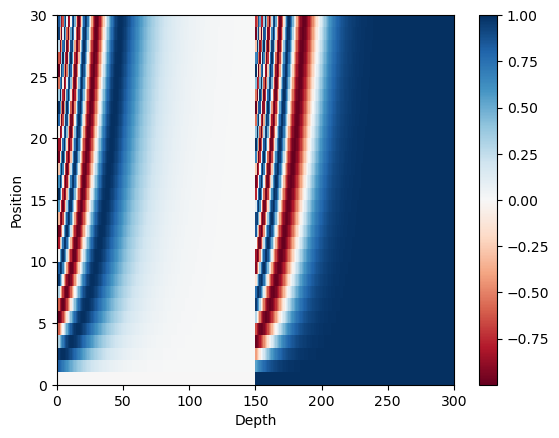

In [5]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap = 'RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 300))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

plot_position_embedding(position_embedding)


In [6]:
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]



In [8]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)



In [ ]:
def scaled_dot_product_attention(q, k, v, mask):

    matmul_qk = tf.matmul(q, k, transpose_b = True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        # 使得在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)

    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis = -1)

    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)


In [9]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)

        self.dense = keras.layers.Dense(self.d_model)

    def split_heads(self, x, batch_size):

        x = tf.reshape(x,
                       (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]

        q = self.WQ(q) 
        k = self.WK(k) 
        v = self.WV(v) 

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)

        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention_outputs,
                                      (batch_size, -1, self.d_model))


        output = self.dense(concat_attention)

        return output, attention_weights




In [10]:
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])



In [ ]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)

        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, x, training, encoder_padding_mask):

        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(x + attn_output)


        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)

        return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)


(64, 50, 512)


In [11]:
class DecoderLayer(keras.layers.Layer):

    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = feed_forward_network(d_model, dff)

        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon = 1e-6)

        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)


    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):


        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(attn1 + x)

        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)

        return out3, attn_weights1, attn_weights2




In [12]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length

        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)

        self.position_embedding = get_position_embedding(max_length,
                                                         self.d_model)

        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]


    def call(self, x, training, encoder_padding_mask):

        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :input_seq_len, :]

        x = self.dropout(x, training = training)

        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training,
                                       encoder_padding_mask)

        return x



In [13]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model

        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)

        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]


    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):

        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")

        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]

        x = self.dropout(x, training = training)

        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                'decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights[
                'decoder_layer{}_att2'.format(i+1)] = attn2

        return x, attention_weights



In [14]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate)

        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate)

        self.final_layer = keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)

        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training,
            decoder_mask, encoder_decoder_padding_mask)

        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)

        return predictions, attention_weights




In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)


In [ ]:
class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomizedSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # 显式将step转换为float32
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)

        return arg3 * tf.math.minimum(arg1, arg2)

learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)



Text(0.5, 0, 'Train step')

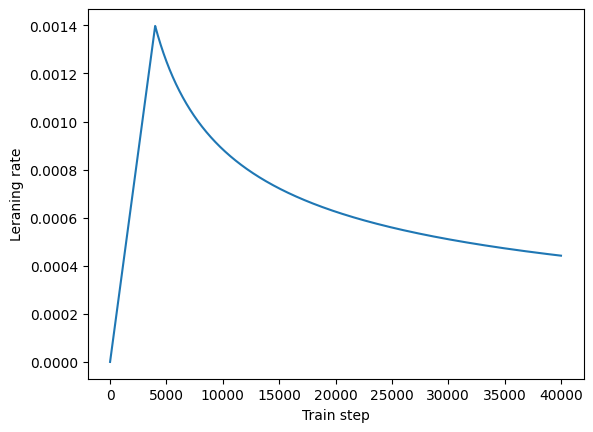

In [ ]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)

plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")


In [ ]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)



In [ ]:
def create_masks(inp, tar):
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask,
                              look_ahead_mask)

    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask


Epoch 1 Batch 0 Loss 4.6206 Accuracy 0.0005


Epoch 1 Batch 100 Loss 4.1571 Accuracy 0.0130
Epoch 1 Batch 200 Loss 4.0766 Accuracy 0.0186
Epoch 1 Batch 300 Loss 3.9208 Accuracy 0.0254
Epoch 1 Batch 400 Loss 3.7445 Accuracy 0.0316
Epoch 1 Batch 500 Loss 3.5971 Accuracy 0.0376
Epoch 1 Batch 600 Loss 3.4728 Accuracy 0.0444
Epoch 1 Batch 700 Loss 3.3673 Accuracy 0.0515
Saved model weights to models/model_epoch_1.h5
Epoch 1 Loss 3.3660 Accuracy 0.0517
Time take for 1 epoch: 524.1632254123688 secs

Epoch 2 Batch 0 Loss 2.4637 Accuracy 0.0925
Epoch 2 Batch 100 Loss 2.5611 Accuracy 0.1056
Epoch 2 Batch 200 Loss 2.5200 Accuracy 0.1094
Epoch 2 Batch 300 Loss 2.4836 Accuracy 0.1129
Epoch 2 Batch 400 Loss 2.4470 Accuracy 0.1161
Epoch 2 Batch 500 Loss 2.4156 Accuracy 0.1191
Epoch 2 Batch 600 Loss 2.3919 Accuracy 0.1217
Epoch 2 Batch 700 Loss 2.3679 Accuracy 0.1241
Saved model weights to models/model_epoch_2.h5
Epoch 2 Loss 2.3674 Accuracy 0.1241
Time take for 1 epoch: 164.98665308952332 secs

Epoch 3 Batch 0 Loss 2.1252 Accuracy 0.1493
Epoch 3

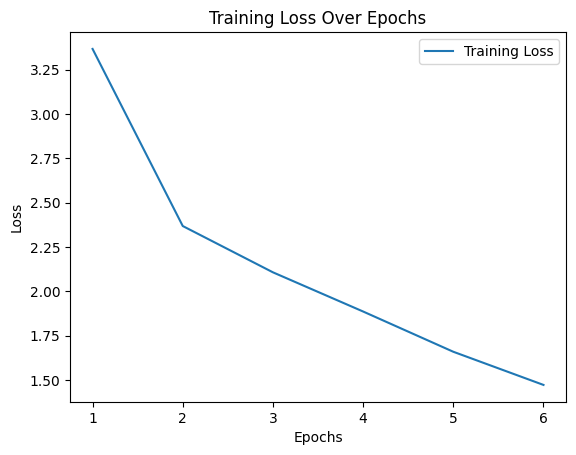

In [ ]:
from tensorflow.keras.models import load_model
import time
import os
import matplotlib.pyplot as plt
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')

@tf.function
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]
    tar_real = tar[:, 1:]

    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

# 存储每个 epoch 的损失值，用于绘制损失函数曲线
train_losses = []

# 创建保存模型的目录
save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)  # 如果目录不存在则创建

epochs = 6
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
    # 记录每个 epoch 的损失值
    train_losses.append(train_loss.result())

    # 在每个 epoch 结束时保存模型权重
    checkpoint_path = os.path.join(save_dir, "model_epoch_{}.h5".format(epoch + 1))
    transformer.save_weights(checkpoint_path)
    print("Saved model weights to", checkpoint_path)

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(
        time.time() - start))

# 绘制损失函数曲线
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]

    encoder_input = tf.expand_dims(input_id_sentence, 0)


    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)

    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)

        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)

        predictions = predictions[:, -1, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis = -1),
                               tf.int32)

        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights

        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights


In [ ]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize = (16, 8))

    input_id_sentence = pt_tokenizer.encode(input_sentence)

    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        ax.matshow(attention[head][:-1, :])

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()


In [ ]:

def translate(input_sentence, target_translation='', layer_name=''):
    result, attention_weights = evaluate(input_sentence)

    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])

    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))

    if target_translation:
        print("Target translation: {}".format(target_translation))

    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                          result, layer_name)



In [ ]:
translate('está muito frio aqui.')


Input: está muito frio aqui.
Predicted translation: it 's very low-dimensional here .


In [ ]:
translate("está muito frio aqui.",
          "it's too cold in here.",)

Input: está muito frio aqui.
Predicted translation: it 's very low-dimensional here .
Target translation: it's too cold in here.


In [ ]:

translate("isto é minha vida.",
          "this is my life.",)

Input: isto é minha vida.
Predicted translation: this is my life .
Target translation: this is my life.


In [ ]:

translate("você ainda está em casa?",
          "Are you still at home?",)

Input: você ainda está em casa?
Predicted translation: do you still get home ?
Target translation: Are you still at home?
